# Emotion Classification Using Transform Layer

In [1]:
%matplotlib inline
%config IPCompleter.greedy = True
%config IPCompleter.merge_completions = True
%config IPCompleter.limit_to__all__ = False
import matplotlib
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import sklearn.datasets
import theano
import theano.tensor as T
import lasagne
import csv

In [2]:
drp = lasagne.layers.DropoutLayer
conv = lasagne.layers.Conv2DLayer
pool = lasagne.layers.MaxPool2DLayer
bnorm = lasagne.layers.batch_norm
CHANNELS_NUM = 1
IMAGE_WIDTH = 48
IMAGE_HIGHT = 48
CLASSES_NUM = 7
EPOCHS_NUM = 500
BATCH_SIZE = 128
LEARNING_RATE = 0.001
DATASET_SIZE = 35887
FILE_NAME = "fer2013/fer2013.csv"

# Data Loading

In [3]:
def load_data():

    X_data = np.zeros((DATASET_SIZE, IMAGE_HIGHT*IMAGE_WIDTH))
    Y_data = np.zeros((DATASET_SIZE,))
    
    i = 0
    with open(FILE_NAME, 'rb') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            X_data[i, :] = np.fromstring(row['pixels'], dtype=int, sep=' ')
            Y_data[i] = row['emotion']
            i = i + 1
            
    X_data = X_data.reshape((-1, CHANNELS_NUM, IMAGE_HIGHT, IMAGE_WIDTH))
    print X_data.shape
    print Y_data.shape
    
    mask = np.random.choice(DATASET_SIZE, int((4.0/5)*DATASET_SIZE))
    X_train = X_data[mask, :, :, :] 
    Y_train = Y_data[mask]
    X_val_tst = X_data[~mask, :, :, :] 
    Y_val_tst = Y_data[~mask]
    val_mask = np.random.choice(X_val_tst.shape[0], int((1.0/10)*DATASET_SIZE))
    X_valid = X_val_tst[val_mask, :, :, :]
    X_test = X_val_tst[~val_mask, :, :, :]
    Y_valid = Y_val_tst[val_mask]
    Y_test = Y_val_tst[~val_mask]
    
    print X_train.shape, X_valid.shape, X_test.shape
    print Y_train.shape, Y_valid.shape, Y_test.shape

    return dict(
        X_train=lasagne.utils.floatX(X_train / 255.0),
        y_train=Y_train.astype('int32'),
        X_valid=lasagne.utils.floatX(X_valid / 255.0),
        y_valid=Y_valid.astype('int32'),
        X_test=lasagne.utils.floatX(X_test / 255.0),
        y_test=Y_test.astype('int32'),
        num_examples_train=X_train.shape[0],
        num_examples_valid=X_valid.shape[0],
        num_examples_test=X_test.shape[0],
        input_height=X_train.shape[2],
        input_width=X_train.shape[3],
        output_dim=CLASSES_NUM,)

(35887, 1, 48, 48)
(35887,)
(28709, 1, 48, 48) (3588, 1, 48, 48) (3588, 1, 48, 48)
(28709,) (3588,) (3588,)


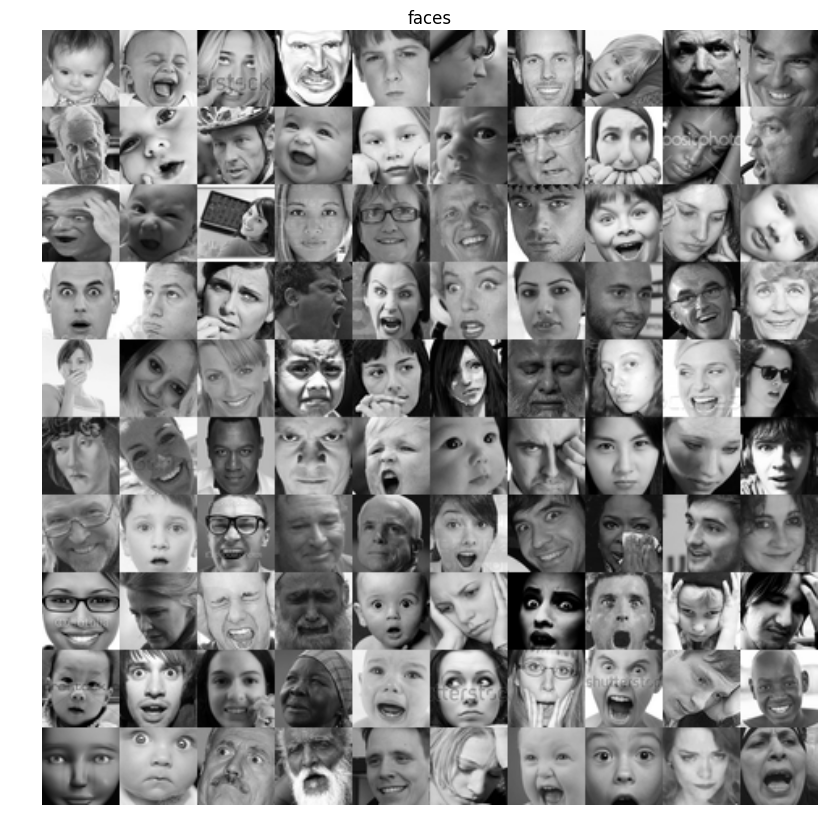

In [4]:
data = load_data()

idx = 0
canvas = np.zeros((IMAGE_HIGHT*10, 10*IMAGE_WIDTH))
for i in range(10):
    for j in range(10):
        canvas[i*IMAGE_HIGHT:(i+1)*IMAGE_HIGHT, j*IMAGE_WIDTH:(j+1)*IMAGE_WIDTH] = data['X_train'][idx].reshape((IMAGE_HIGHT, IMAGE_WIDTH))
        idx += 1
plt.figure(figsize=(10, 10))
plt.imshow(canvas, cmap='gray')
plt.title('faces')
plt.axis('off')

plt.show()

# Model Building

In [5]:
def build_model(input_width, input_height, output_dim,
                batch_size=BATCH_SIZE):
    ini = lasagne.init.HeUniform()
    l_in = lasagne.layers.InputLayer(shape=(None, 1, input_width, input_height),)
    
    # Classification network
    class_l1 = bnorm(conv(
        l_in,
        num_filters=16,
        filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    ))
    l_drp1 = drp(class_l1, p=0.4)
    class_l3 = bnorm(conv(
        l_drp1,
        num_filters=16,
        filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    ))
    l_drp2 = drp(class_l3, p=0.4)
    class_l4 = bnorm(conv(
        l_drp2,
        num_filters=8,
        filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    ))
    l_drp3 = drp(class_l4, p=0.4)
    class_l5 = bnorm(lasagne.layers.DenseLayer(
        l_drp3,
        num_units=256,
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    ))
    l_drp3 = drp(class_l5, p=0.4)
    l_out = bnorm(lasagne.layers.DenseLayer(
        l_drp3,
        num_units=output_dim,
        nonlinearity=lasagne.nonlinearities.softmax,
        W=ini,
    ))

    return l_out

In [6]:
X = T.tensor4()
y = T.ivector()

model = build_model(IMAGE_HIGHT, IMAGE_WIDTH, CLASSES_NUM)
model_params = lasagne.layers.get_all_params(model, trainable=True)

# training output
output_train = lasagne.layers.get_output(model, X, deterministic=False)

# evaluation output. Also includes output of transform for plotting
output_eval = lasagne.layers.get_output([model], X, deterministic=True)

sh_lr = theano.shared(lasagne.utils.floatX(LEARNING_RATE))
cost = T.mean(T.nnet.categorical_crossentropy(output_train, y))
updates = lasagne.updates.adam(cost, model_params, learning_rate=sh_lr)

train = theano.function([X, y], [cost, output_train], updates=updates)
eval = theano.function([X], output_eval)

# Model Training

In [9]:
def train_epoch(X, y):
    num_samples = X.shape[0]
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))
    costs = []
    correct = 0
    for i in range(num_batches):
        if i % 10 == 0:
            print i,
        idx = range(i*BATCH_SIZE, np.minimum((i+1)*BATCH_SIZE, num_samples))
        X_batch = X[idx]
        y_batch = y[idx]
        cost_batch, output_train = train(X_batch, y_batch)
        costs += [cost_batch]
        preds = np.argmax(output_train, axis=-1)
        correct += np.sum(y_batch == preds)
    print ""
    return np.mean(costs), correct / float(num_samples)


def eval_epoch(X, y):
    output_eval = eval(X)
    preds = np.argmax(output_eval, axis=-1)
    acc = np.mean(preds == y)
    return acc

In [ ]:
valid_accs, train_accs, test_accs = [], [], []
try:
    for n in range(EPOCHS_NUM):
        train_cost, train_acc = train_epoch(data['X_train'], data['y_train'])
        valid_acc = eval_epoch(data['X_valid'], data['y_valid'])
        test_acc = eval_epoch(data['X_test'], data['y_test'])
        valid_accs += [valid_acc]
        test_accs += [test_acc]
        train_accs += [train_acc]

        if (n+1) % 20 == 0:
            new_lr = sh_lr.get_value() * 0.7
            print "New LR:", new_lr
            sh_lr.set_value(lasagne.utils.floatX(new_lr))
            #store
            all_params = lasagne.layers.get_all_params(model)
            all_param_values = [p.get_value() for p in all_params]

            output = open('params.oo', 'wb')
            pickle.dump(all_param_values, output)
            output.close()
            
            
        print "Epoch {0}: Train cost {1}, Train acc {2}, val acc {3}, test acc {4}".format(
                n, train_cost, train_acc, valid_acc, test_acc)
except KeyboardInterrupt:
    pass

0

# Plotting

In [ ]:
plt.figure(figsize=(9,9))
plt.plot(1-np.array(train_accs), label='Training Error')
plt.plot(1-np.array(valid_accs), label='Validation Error')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Error', fontsize=20)
plt.show()

In [ ]:
plt.figure(figsize=(7,14))
for i in range(3):
    plt.subplot(321+i*2)
    plt.imshow(data['X_test'][i].reshape(IMAGE_HIGHT, IMAGE_WIDTH), cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Original', fontsize=20)
    plt.axis('off')
    plt.subplot(322+i*2)
    plt.imshow(test_transform[i].reshape(IMAGE_HIGHT, IMAGE_WIDTH), cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Transformed', fontsize=20)
    plt.axis('off')
    
plt.show()